## Model Results

In this notebook someone can expect to find validations and tests of our models on the M4A dataset. The notebook is sectioned into three parts each one testing and validating in each modality the genre and emotion models.

### Lyrical Modality

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import pandas as pd
from sklearn.metrics import accuracy_score
import tqdm
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import string
import torch.nn.functional as F
import json
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
columns_to_keep = ['id', 'primary_short', 'emotion']

train_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/train.json', lines=True)
val_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/val.json', lines=True)
test_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/test.json', lines=True)

train_df = train_df[columns_to_keep]
val_df = val_df[columns_to_keep]
test_df = test_df[columns_to_keep]

genre_label_encoder = LabelEncoder()
train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])
test_df['genre_label'] = genre_label_encoder.transform(test_df['primary_short'])

emotion_label_encoder = LabelEncoder()
train_df['emotion_label'] = emotion_label_encoder.fit_transform(train_df['emotion'])
val_df['emotion_label'] = emotion_label_encoder.transform(val_df['emotion'])
test_df['emotion_label'] = emotion_label_encoder.transform(test_df['emotion'])

<ipython-input-2-111c4b096bfe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
<ipython-input-2-111c4b096bfe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
with open('./drive/MyDrive/Diploma/Data_Final/tokenized_texts.json', 'r') as f:
    json_file = json.load(f)

class GenreLyricsDataset(Dataset):
    def __init__(self, dataframe, json_file):
        self.len = len(dataframe)
        self.data = dataframe
        self.json = json_file

    def __getitem__(self, index):
        identification = self.data.id[index]
        ids, mask = self.json[identification].values()

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.int),
            'targets': torch.tensor(self.data.genre_label[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

class EmotionLyricsDataset(Dataset):
    def __init__(self, dataframe, json_file):
        self.len = len(dataframe)
        self.data = dataframe
        self.json = json_file

    def __getitem__(self, index):
        identification = self.data.id[index]
        ids, mask = self.json[identification].values()

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.int),
            'targets': torch.tensor(self.data.emotion_label[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

emotion_lyrics_train_set = EmotionLyricsDataset(train_df, json_file)
emotion_lyrics_val_set = EmotionLyricsDataset(val_df, json_file)
emotion_lyrics_test_set = EmotionLyricsDataset(test_df, json_file)

emotion_lyrics_train_loader = DataLoader(emotion_lyrics_train_set, batch_size=10, shuffle=True)
emotion_lyrics_val_loader = DataLoader(emotion_lyrics_val_set, batch_size=32)
emotion_lyrics_test_loader = DataLoader(emotion_lyrics_test_set, batch_size=32)

genre_lyrics_train_set = GenreLyricsDataset(train_df, json_file)
genre_lyrics_val_set = GenreLyricsDataset(val_df, json_file)
genre_lyrics_test_set = GenreLyricsDataset(test_df, json_file)

genre_lyrics_train_loader = DataLoader(genre_lyrics_train_set, batch_size=10, shuffle=True)
genre_lyrics_val_loader = DataLoader(genre_lyrics_val_set, batch_size=32)
genre_lyrics_test_loader = DataLoader(genre_lyrics_test_set, batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def validate_lyrics_model(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for _, data in tqdm.tqdm(enumerate(val_loader, 0)):
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            val_loss += torch.nn.functional.cross_entropy(outputs.logits, targets, reduction='sum').item()
            pred = torch.argmax(outputs.logits, dim=1)
            correct += pred.eq(targets).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, accuracy


def test_lyrics_model(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _, batch in enumerate(test_loader, 0):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy}")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    conf_matrix = confusion_matrix(all_labels, all_preds)

    colors = ["#373E40", "#B7D5D4", "#ffffff"]
    cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmap,
                     xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                     cbar_kws={'label': 'Frequency'})

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, conf_matrix

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-8-9d1f7f413690>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Starting validation...


205it [05:03,  1.48s/it]


Validation Loss: 1.5130403317749954
Validation Accuracy: 46.900763358778626%

Starting testing...
Test Accuracy: 0.45145038167938933
Classification Report:
                  precision    recall  f1-score   support

alternative rock       0.24      0.41      0.30       504
      electronic       0.48      0.20      0.29       677
            folk       0.50      0.37      0.42       648
     heavy music       0.63      0.67      0.65      1025
         hip hop       0.86      0.87      0.86       324
             pop       0.45      0.59      0.51      1146
            punk       0.38      0.17      0.23       634
    rhythm music       0.61      0.44      0.51       666
            rock       0.27      0.35      0.30       926

        accuracy                           0.45      6550
       macro avg       0.49      0.45      0.45      6550
    weighted avg       0.47      0.45      0.45      6550



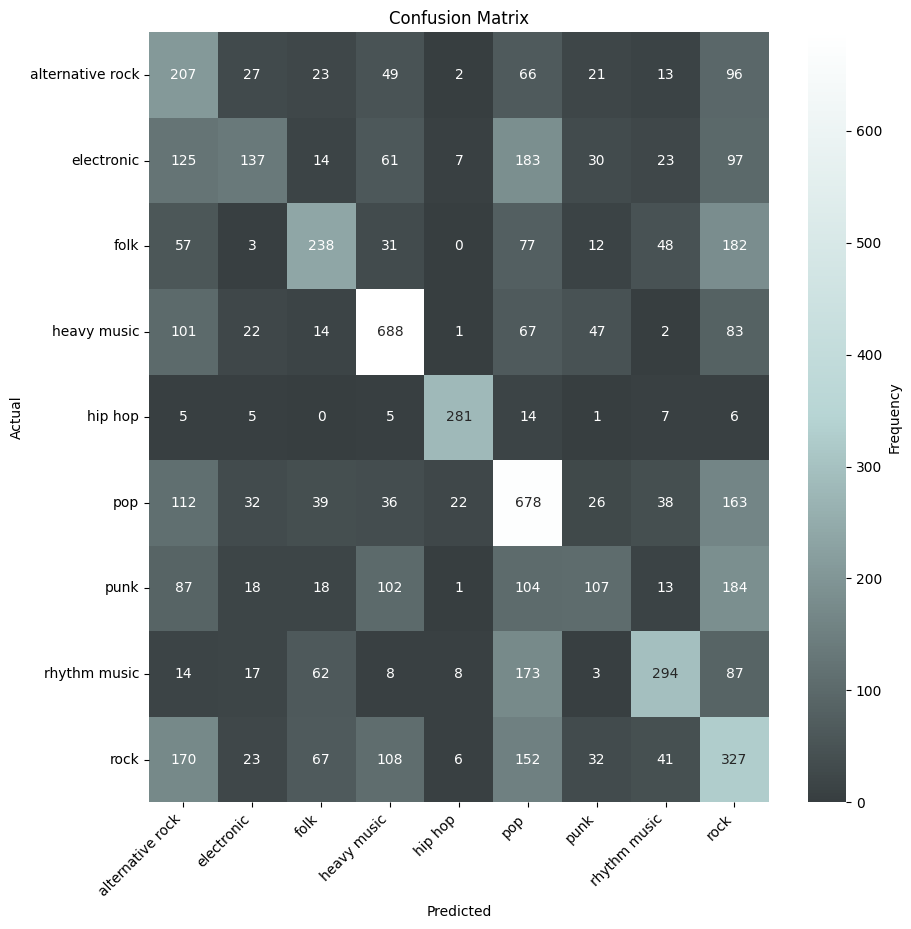

Test Accuracy: 0.45145038167938933%


In [ ]:
genre_lyrics_model = AutoModelForSequenceClassification.from_pretrained('roberta-large', num_labels=9).to(device)
genre_lyrics_model.load_state_dict(torch.load('./drive/MyDrive/Diploma/Data_Final/genre_lyrics'))

print("Starting validation...")
val_loss, val_accuracy = validate_lyrics_model(genre_lyrics_model, genre_lyrics_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing...")
test_accuracy, conf_matrix = test_lyrics_model(genre_lyrics_model, genre_lyrics_test_loader, genre_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-9-0c6f9d92e28d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowli

Starting validation...


205it [05:03,  1.48s/it]


Validation Loss: 1.7742062459465202
Validation Accuracy: 34.030534351145036%

Starting testing...
Test Accuracy: 0.3233587786259542
Classification Report:
              precision    recall  f1-score   support

       Angry       0.40      0.56      0.47      1203
        Calm       0.37      0.38      0.38       349
   Depressed       0.24      0.16      0.19       416
     Excited       0.35      0.51      0.41      1182
       Happy       0.34      0.11      0.16       525
     Neutral       0.25      0.05      0.09       678
     Relaxed       0.42      0.05      0.08       110
         Sad       0.22      0.25      0.24       760
       Tense       0.27      0.27      0.27      1327

    accuracy                           0.32      6550
   macro avg       0.32      0.26      0.25      6550
weighted avg       0.31      0.32      0.30      6550



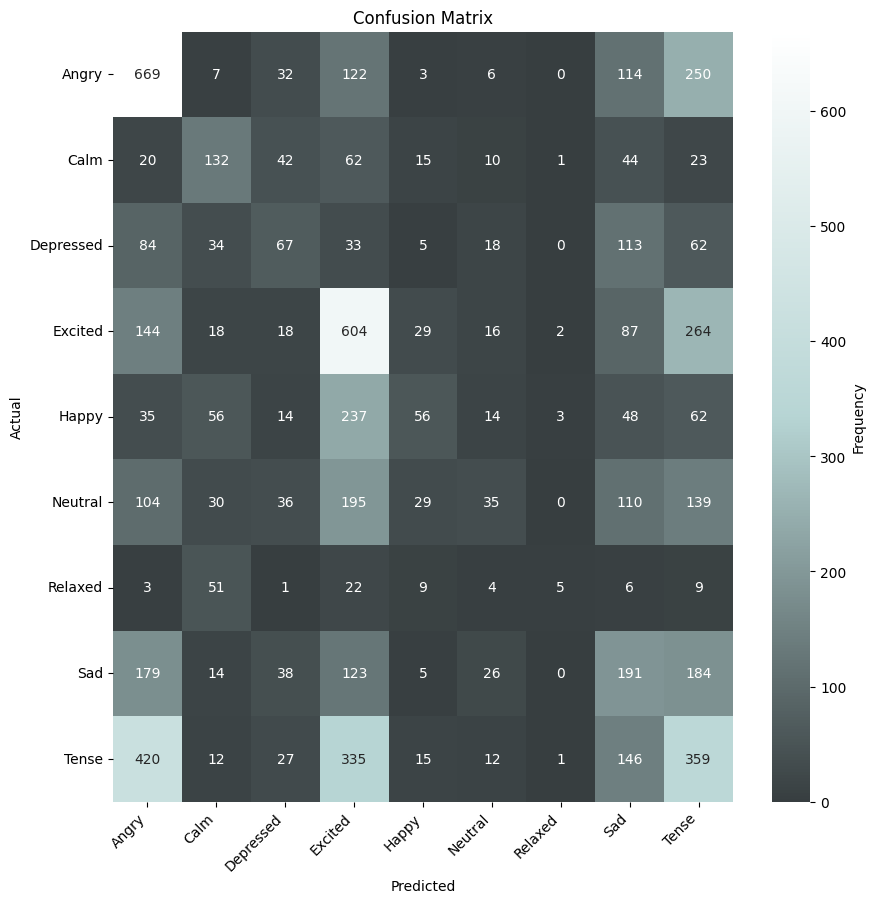

Test Accuracy: 0.3233587786259542%


In [ ]:
emotion_lyrics_model = AutoModelForSequenceClassification.from_pretrained('roberta-large', num_labels=9).to(device)
emotion_lyrics_model.load_state_dict(torch.load('./drive/MyDrive/Diploma/Data_Final/emotion_lyrics'))

print("Starting validation...")
val_loss, val_accuracy = validate_lyrics_model(emotion_lyrics_model, emotion_lyrics_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing...")
test_accuracy, conf_matrix = test_lyrics_model(emotion_lyrics_model, emotion_lyrics_test_loader, emotion_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

### Audio Modality

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaModel, AutoModel
from transformers import AutoModelForAudioClassification, ASTModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error
import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
import pickle
import glob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def convert_pickles_to_npy(pickle_folder_path, npy_folder_path):
    if not os.path.exists(npy_folder_path):
        os.makedirs(npy_folder_path)

    pickle_files = glob.glob(os.path.join(pickle_folder_path, '*.pkl'))
    for pickle_file in tqdm.tqdm(pickle_files):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            for key, [spectrogram] in data.items():
                npy_path = os.path.join(npy_folder_path, f"{key}.npy")
                np.save(npy_path, spectrogram)

convert_pickles_to_npy('./drive/MyDrive/Diploma/Data_Final/spectogram_pikles', './audio-spectograms-npy')

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

In [ ]:
columns_to_keep = ['id', 'primary_short', 'emotion']

train_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/train.json', lines=True)
val_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/val.json', lines=True)
test_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/test.json', lines=True)

train_df = train_df[columns_to_keep]
val_df = val_df[columns_to_keep]
test_df = test_df[columns_to_keep]

genre_label_encoder = LabelEncoder()
train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])
test_df['genre_label'] = genre_label_encoder.transform(test_df['primary_short'])

emotion_label_encoder = LabelEncoder()
train_df['emotion_label'] = emotion_label_encoder.fit_transform(train_df['emotion'])
val_df['emotion_label'] = emotion_label_encoder.transform(val_df['emotion'])
test_df['emotion_label'] = emotion_label_encoder.transform(test_df['emotion'])

<ipython-input-3-111c4b096bfe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
<ipython-input-3-111c4b096bfe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])
<ipython-input-3-111c4b096bfe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
class SpectrogramsEmotionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        identification = self.data.iloc[index]['id']
        label = self.data.iloc[index]['emotion_label']
        spectogram = np.load(os.path.join('./audio-spectograms-npy', f"{identification}.npy"))

        return {
            'spectograms': spectogram,
            'targets': label
        }

class SpectrogramsGenreDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        identification = self.data.iloc[index]['id']
        label = self.data.iloc[index]['genre_label']
        spectogram = np.load(os.path.join('./audio-spectograms-npy', f"{identification}.npy"))

        return {
            'spectograms': spectogram,
            'targets': label
        }

genre_audio_train_set = SpectrogramsGenreDataset(train_df)
genre_audio_val_set = SpectrogramsGenreDataset(val_df)
genre_audio_test_set = SpectrogramsGenreDataset(test_df)

genre_audio_train_loader = DataLoader(genre_audio_train_set, batch_size=8, shuffle=True)
genre_audio_val_loader = DataLoader(genre_audio_val_set, batch_size=8)
genre_audio_test_loader = DataLoader(genre_audio_test_set, batch_size=8)

emotion_audio_train_set = SpectrogramsEmotionDataset(train_df)
emotion_audio_val_set = SpectrogramsEmotionDataset(val_df)
emotion_audio_test_set = SpectrogramsEmotionDataset(test_df)

emotion_audio_train_loader = DataLoader(emotion_audio_train_set, batch_size=8, shuffle=True)
emotion_audio_val_loader = DataLoader(emotion_audio_val_set, batch_size=8)
emotion_audio_test_loader = DataLoader(emotion_audio_test_set, batch_size=8)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def validate_audio_model(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for _, data in tqdm.tqdm(enumerate(val_loader, 0)):
            spectrograms = data['spectograms'].to(device)
            targets = data['targets'].to(device)

            outputs = model(spectrograms)
            val_loss += torch.nn.functional.cross_entropy(outputs.logits, targets, reduction='sum').item()
            pred = outputs.logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

def test_audio_model(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            spectrograms = batch['spectograms'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(spectrograms)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    conf_matrix = confusion_matrix(all_labels, all_preds)

    colors = ["#373E40", "#B7D5D4", "#ffffff"]
    cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmap,
                     xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                     cbar_kws={'label': 'Frequency'})

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Emotion Audio Confusion Matrix')
    plt.show()

    return test_accuracy, conf_matrix

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-17be7cf9cd5c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be 

Starting validation...
Validation Loss: 1.2999297274888018
Validation Accuracy: 48.33587786259542%

Starting testing...
Test Accuracy: 48.29%
Classification Report:
              precision    recall  f1-score   support

       Angry       0.52      0.69      0.59      1203
        Calm       0.51      0.60      0.55       349
   Depressed       0.59      0.47      0.52       416
     Excited       0.48      0.70      0.57      1182
       Happy       0.46      0.37      0.41       525
     Neutral       0.37      0.27      0.32       678
     Relaxed       0.50      0.04      0.07       110
         Sad       0.45      0.50      0.47       760
       Tense       0.47      0.26      0.33      1327

    accuracy                           0.48      6550
   macro avg       0.48      0.43      0.43      6550
weighted avg       0.48      0.48      0.46      6550



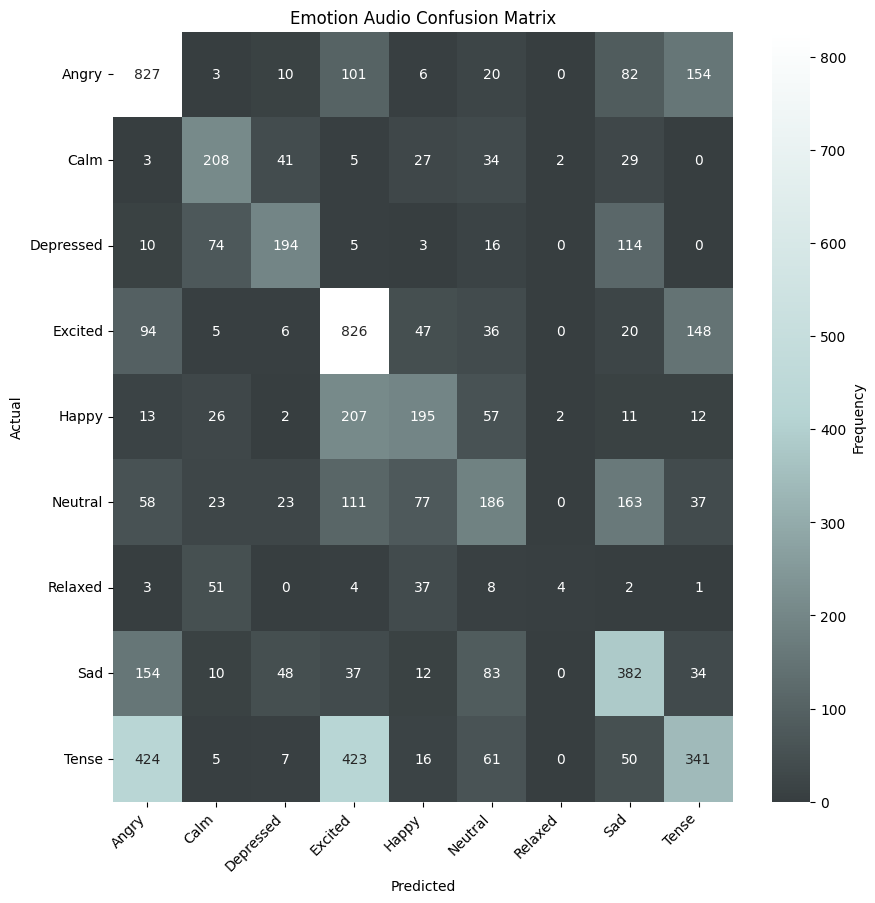

In [ ]:
emotion_audio_model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=9, ignore_mismatched_sizes=True).to(device)
emotion_audio_model.load_state_dict(torch.load('./drive/MyDrive/Diploma/Data_Final/emotion_audio'))

print("Starting validation...")
val_loss, val_accuracy = validate_audio_model(emotion_audio_model, emotion_audio_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing...")
test_accuracy, conf_matrix = test_audio_model(emotion_audio_model, emotion_audio_test_loader, emotion_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-350ee6c894d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be 

Starting validation...
Validation Loss: 1.3477120788952777
Validation Accuracy: 55.63358778625954%

Starting testing...
Test Accuracy: 53.76%
Classification Report:
                  precision    recall  f1-score   support

alternative rock       0.27      0.35      0.30       504
      electronic       0.60      0.44      0.51       677
            folk       0.61      0.48      0.54       648
     heavy music       0.74      0.73      0.73      1025
         hip hop       0.78      0.82      0.80       324
             pop       0.51      0.60      0.55      1146
            punk       0.60      0.33      0.43       634
    rhythm music       0.57      0.61      0.59       666
            rock       0.37      0.45      0.41       926

        accuracy                           0.54      6550
       macro avg       0.56      0.53      0.54      6550
    weighted avg       0.55      0.54      0.54      6550



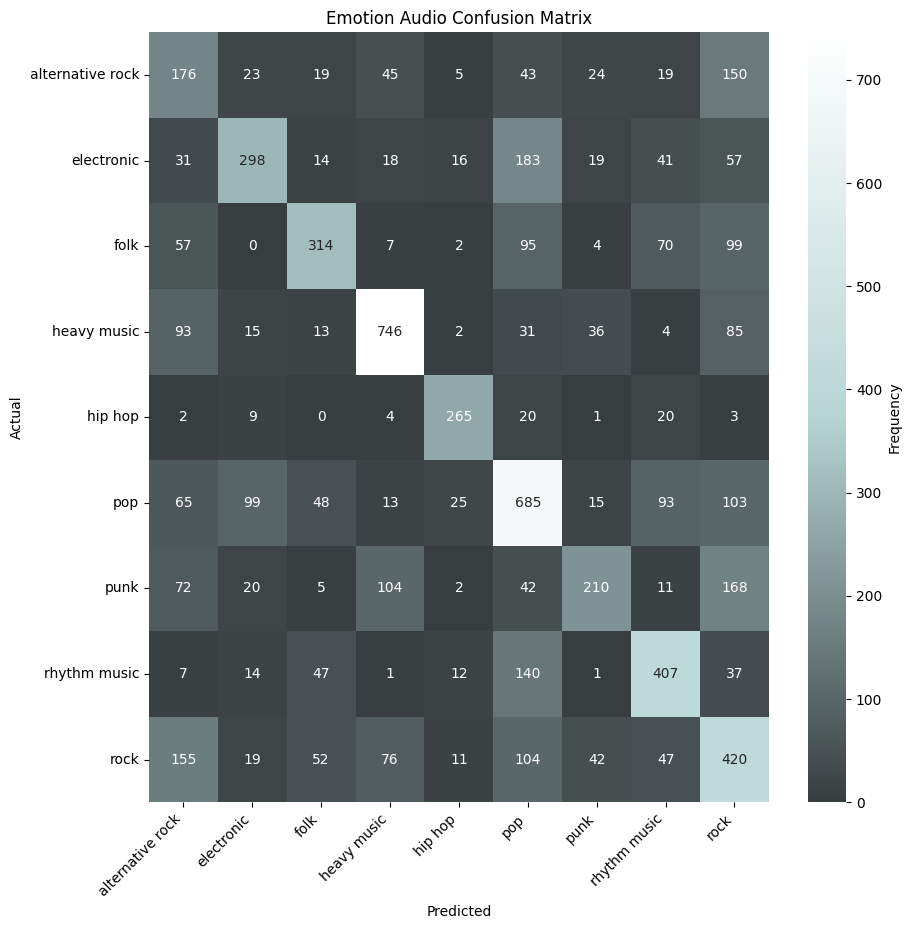

Test Accuracy: 0.537557251908397%


In [ ]:
genre_audio_model = AutoModelForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", num_labels=9, ignore_mismatched_sizes=True).to(device)
genre_audio_model.load_state_dict(torch.load('./drive/MyDrive/Diploma/Data_Final/genre_audio'))

print("Starting validation...")
val_loss, val_accuracy = validate_audio_model(genre_audio_model, genre_audio_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing...")
test_accuracy, conf_matrix = test_audio_model(genre_audio_model, genre_audio_test_loader, genre_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

### Multimodal Modality

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaModel, AutoModel
from transformers import AutoModelForAudioClassification, ASTModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error
import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
import pickle
import glob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import json
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def convert_pickles_to_npy(pickle_folder_path, npy_folder_path):
    if not os.path.exists(npy_folder_path):
        os.makedirs(npy_folder_path)

    pickle_files = glob.glob(os.path.join(pickle_folder_path, '*.pkl'))
    for pickle_file in tqdm.tqdm(pickle_files):
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            for key, [spectrogram] in data.items():
                npy_path = os.path.join(npy_folder_path, f"{key}.npy")
                np.save(npy_path, spectrogram)

convert_pickles_to_npy('./drive/MyDrive/Diploma/Data_Final/spectogram_pikles', './audio-spectograms-npy')


In [ ]:
columns_to_keep = ['id', 'primary_short', 'emotion']

train_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/train.json', lines=True)
val_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/val.json', lines=True)
test_df = pd.read_json('./drive/MyDrive/Diploma/Data_Final/final_split/test.json', lines=True)

train_df = train_df[columns_to_keep]
val_df = val_df[columns_to_keep]
test_df = test_df[columns_to_keep]

genre_label_encoder = LabelEncoder()
train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])
test_df['genre_label'] = genre_label_encoder.transform(test_df['primary_short'])

emotion_label_encoder = LabelEncoder()
train_df['emotion_label'] = emotion_label_encoder.fit_transform(train_df['emotion'])
val_df['emotion_label'] = emotion_label_encoder.transform(val_df['emotion'])
test_df['emotion_label'] = emotion_label_encoder.transform(test_df['emotion'])

<ipython-input-22-111c4b096bfe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['genre_label'] = genre_label_encoder.fit_transform(train_df['primary_short'])
<ipython-input-22-111c4b096bfe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['genre_label'] = genre_label_encoder.transform(val_df['primary_short'])
<ipython-input-22-111c4b096bfe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")
with open('./drive/MyDrive/Diploma/Data_Final/tokenized_texts.json', 'r') as f:
    json_file = json.load(f)

class MultimodalEmotionDataset(Dataset):
    def __init__(self, dataframe, json_file):
        self.data = dataframe
        self.json = json_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        identification = self.data.iloc[index]['id']
        label = self.data.iloc[index]['emotion_label']
        spectogram = np.load(os.path.join('./audio-spectograms-npy', f"{identification}.npy"))
        ids, mask = self.json[identification].values()

        return {
            'spectograms': spectogram,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.int),
            'targets': label
        }

class MultimodalGenreDataset(Dataset):
    def __init__(self, dataframe, json_file):
        self.data = dataframe
        self.json = json_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        identification = self.data.iloc[index]['id']
        label = self.data.iloc[index]['genre_label']
        spectogram = np.load(os.path.join('./audio-spectograms-npy', f"{identification}.npy"))
        ids, mask = self.json[identification].values()

        return {
            'spectograms': spectogram,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.int),
            'targets': label
        }

genre_multimodal_train_set = MultimodalGenreDataset(train_df, json_file)
genre_multimodal_val_set = MultimodalGenreDataset(val_df, json_file)
genre_multimodal_test_set = MultimodalGenreDataset(test_df, json_file)

genre_multimodal_train_loader = DataLoader(genre_multimodal_train_set, batch_size=3, shuffle=True)
genre_multimodal_val_loader = DataLoader(genre_multimodal_val_set, batch_size=3)
genre_multimodal_test_loader = DataLoader(genre_multimodal_test_set, batch_size=3)

emotion_multimodal_train_set = MultimodalEmotionDataset(train_df, json_file)
emotion_multimodal_val_set = MultimodalEmotionDataset(val_df, json_file)
emotion_multimodal_test_set = MultimodalEmotionDataset(test_df, json_file)

emotion_multimodal_train_loader = DataLoader(emotion_multimodal_train_set, batch_size=3, shuffle=True)
emotion_multimodal_val_loader = DataLoader(emotion_multimodal_val_set, batch_size=3)
emotion_multimodal_test_loader = DataLoader(emotion_multimodal_test_set, batch_size=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def validate_multimodal_model(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for _, batch in enumerate(val_loader, 0):
            input_values = batch['spectograms'].to(device)
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_values=input_values, input_ids=ids, attention_mask=mask)
            val_loss += torch.nn.functional.cross_entropy(outputs, targets, reduction='sum').item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

def test_multimodal_model(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _, batch in enumerate(test_loader):
            input_values = batch['spectograms'].to(device)
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_values=input_values, input_ids=ids, attention_mask=mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    conf_matrix = confusion_matrix(all_labels, all_preds)

    colors = ["#373E40", "#B7D5D4", "#ffffff"]
    cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmap,
                     xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                     cbar_kws={'label': 'Frequency'})

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Multimodal Confusion Matrix')
    plt.show()

    return test_accuracy, conf_matrix

In [ ]:
class CombinedClassificationHead(nn.Module):
    def __init__(self, audio_feature_size, text_feature_size, num_labels):
        super().__init__()
        combined_feature_size = audio_feature_size + text_feature_size
        self.layer_norm = nn.LayerNorm(combined_feature_size)
        self.fc = nn.Linear(combined_feature_size, num_labels)

    def forward(self, combined_features):
        normalized_features = self.layer_norm(combined_features)
        logits = self.fc(normalized_features)
        return logits

class AudioTextClassificationModel(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.audio_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
        self.text_model = RobertaModel.from_pretrained('roberta-large')

        audio_feature_size = self.audio_model.config.hidden_size
        text_feature_size = self.text_model.config.hidden_size

        self.classifier = CombinedClassificationHead(audio_feature_size, text_feature_size, num_labels)

    def forward(self, input_values, input_ids, attention_mask):
        audio_output = self.audio_model(input_values=input_values)
        audio_pooled_output = audio_output[1]

        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = text_output[0]
        text_pooled_output = sequence_output[:, 0]

        combined_features = torch.cat((audio_pooled_output, text_pooled_output), dim=1)
        class_logits = self.classifier(combined_features)
        return class_logits

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-96f12216b1e7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

Starting validation for emotion multimodal model...
Validation Loss: 1.2940051316168473
Validation Accuracy: 49.05343511450382%

Starting testing for emotion multimodal model...
Test Accuracy: 48.53%
Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.66      0.59      1203
        Calm       0.66      0.41      0.50       349
   Depressed       0.57      0.56      0.57       416
     Excited       0.50      0.69      0.58      1182
       Happy       0.48      0.33      0.39       525
     Neutral       0.33      0.40      0.36       678
     Relaxed       0.38      0.20      0.26       110
         Sad       0.47      0.40      0.43       760
       Tense       0.44      0.33      0.38      1327

    accuracy                           0.49      6550
   macro avg       0.49      0.44      0.45      6550
weighted avg       0.49      0.49      0.48      6550



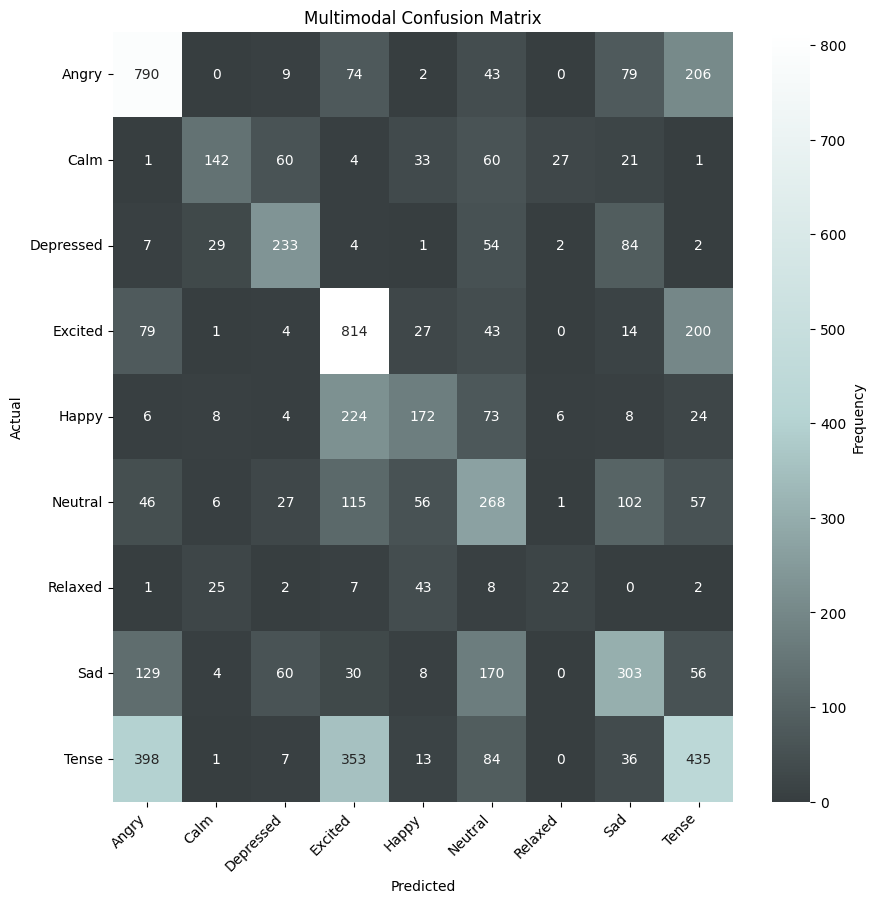

Test Accuracy: 0.4853435114503817%


In [ ]:
emotion_multimodal_model = AudioTextClassificationModel(num_labels=len(emotion_label_encoder.classes_))
emotion_multimodal_model.to(device)
checkpoint = torch.load('./drive/MyDrive/Diploma/Data_Final/emotion_multimodal_3')
emotion_multimodal_model.load_state_dict(checkpoint['model_state_dict'])

print("Starting validation for emotion multimodal model...")
val_loss, val_accuracy = validate_multimodal_model(emotion_multimodal_model, emotion_multimodal_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing for emotion multimodal model...")
test_accuracy, conf_matrix = test_multimodal_model(emotion_multimodal_model, emotion_multimodal_test_loader, emotion_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

In [ ]:
genre_multimodal_model = AudioTextClassificationModel(num_labels=len(genre_label_encoder.classes_))
genre_multimodal_model.to(device)
checkpoint = torch.load('./drive/MyDrive/Diploma/Data_Final/genre_multimodal_3')
genre_multimodal_model.load_state_dict(checkpoint['model_state_dict'])

print("Starting validation for genre multimodal model...")
val_loss, val_accuracy = validate_multimodal_model(genre_multimodal_model, genre_multimodal_val_loader)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}%")

print("\nStarting testing for genre multimodal model...")
test_accuracy, conf_matrix = test_multimodal_model(genre_multimodal_model, genre_multimodal_test_loader, genre_label_encoder)
print(f"Test Accuracy: {test_accuracy}%")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-28-f243151997e3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

Starting validation for genre multimodal model...
Validation Loss: 1.1160881261874473
Validation Accuracy: 60.33587786259542%

Starting testing for genre multimodal model...
Test Accuracy: 57.34%
Classification Report:
                  precision    recall  f1-score   support

alternative rock       0.30      0.37      0.33       504
      electronic       0.58      0.51      0.55       677
            folk       0.63      0.60      0.62       648
     heavy music       0.81      0.75      0.78      1025
         hip hop       0.89      0.89      0.89       324
             pop       0.51      0.66      0.57      1146
            punk       0.61      0.40      0.49       634
    rhythm music       0.73      0.57      0.64       666
            rock       0.38      0.42      0.40       926

        accuracy                           0.57      6550
       macro avg       0.60      0.57      0.58      6550
    weighted avg       0.59      0.57      0.58      6550

